

*   **Plan A**\
  Use greedy sparse attack\
  Give special weight to the location of the watermark
*   **Plan B**\
  Use optimal-based method\
  Take watermark extraction integrity as one of the optimization goals





In [39]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
import torch

In [40]:
# file address in google drive
# file_root = 'drive/MyDrive/Colab Notebooks/adv_watermark/'
file_root = './'

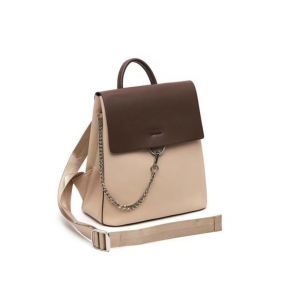

In [41]:
# load and show original image
img = cv2.imread('%sbag2.jpg'%file_root)
target = torch.tensor([162]).cuda()
img = cv2.cvtColor(img,cv2.COLOR_BGR2RGB)
plt.figure(figsize=(5,5))
plt.axis('off')
plt.imshow(img)

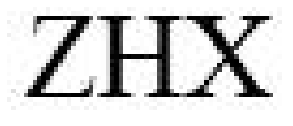

In [42]:
# load and show watermark image
wm = cv2.imread('%szhx3.jpg'%file_root,cv2.IMREAD_GRAYSCALE)
plt.figure(figsize=(5,5))
plt.axis('off')
plt.imshow(wm,cmap='gray')

In [43]:
# watermark embedding parameters
alpha = 5
block_size = 4
k1 = np.random.randn(block_size)
k2 = np.random.randn(block_size)
# add border to image so that it can be divided perfectly with block_size
img = cv2.copyMakeBorder(img,
              0,(block_size-(img.shape[0] % block_size)),
              0,(block_size-(img.shape[1] % block_size)),
              cv2.BORDER_REPLICATE)

In [44]:
# tranform an image from original image to dct blocks
# param bk: a 2-dim numpy array
# param block_size: int
def dct_img(bk,block_size):
  img_dct_blocks_h = bk.shape[0] // block_size
  img_dct_blocks_w = bk.shape[1] // block_size
  img_dct_blocks = np.zeros(shape=(
      (img_dct_blocks_h,img_dct_blocks_w,block_size,block_size)
  ))
  h_data = np.vsplit(bk,img_dct_blocks_h)
  for h in range(img_dct_blocks_h):
    block_data = np.hsplit(h_data[h],img_dct_blocks_w)
    for w in range(img_dct_blocks_w):
        a_block = block_data[w]
        img_dct_blocks[h,w,...] = cv2.dct(a_block.astype(np.float64))
  return img_dct_blocks

In [81]:
# embed gray-scale watermrk into original RGB image
# param img: original image (3-dim RGB)
# param wm: watermark image (2-dim gray)
# param k1/k2: block-size 1-dim numpy array
# param alpha: embed strength
def embed_wm(img,wm,block_size,k1,k2,alpha,x=0,y=0):
  wm = np.where(wm<np.mean(wm),0,1)
  yuv_img = cv2.cvtColor(img,cv2.COLOR_RGB2YUV)
  Y,U,V = yuv_img[...,0],yuv_img[...,1],yuv_img[...,2]
  bk = U
  img_dct_blocks = dct_img(bk,block_size)
  dct_embed_result = img_dct_blocks.copy()
  if (wm.shape[0]+x>img_dct_blocks.shape[0] or wm.shape[1]+y>img_dct_blocks.shape[1]):
    print('Illegal location')
    return None
  for h in range(x,wm.shape[0]+x):
      for w in range(y,wm.shape[1]+y):
          k = k1 if wm[h-x,w-y] == 1 else k2
          for i in range(block_size):
              dct_embed_result[h,w,i,block_size-1] = \
              img_dct_blocks[h,w,i,block_size-1] + alpha * k[i]
  row = None
  idct_result = None
  for h in range(dct_embed_result.shape[0]):
      for w in range(dct_embed_result.shape[1]):
          block = cv2.idct(dct_embed_result[h,w,...])
          row = block if w == 0 else np.hstack((row,block))
      idct_result = row if h == 0 else np.vstack((idct_result,row))
  img_embed_result_yuv = np.stack((Y,idct_result,V),axis=2).astype(np.uint8)
  img_embed_result_bgr = cv2.cvtColor(img_embed_result_yuv,cv2.COLOR_YUV2BGR)
  img_embed_result = cv2.cvtColor(img_embed_result_bgr,cv2.COLOR_BGR2RGB)
  return img_embed_result

In [46]:
def mean2(x):
    y = np.sum(x) / np.size(x);
    return y
# correlation estimation
def corr2(a, b):
    a = a - mean2(a)
    b = b - mean2(b)
    r = (a * b).sum() / (np.sqrt((a * a).sum() * (b * b).sum())+1e-9)
    return r
# PSNR evaluation
def PSNRLossnp(y_true,y_pred):
    return 10* np.log(255*2 / (np.mean(np.square(y_pred - y_true))))

In [88]:
def SSIMnp(y_true , y_pred):
    u_true = np.mean(y_true)
    u_pred = np.mean(y_pred)
    var_true = np.var(y_true)
    var_pred = np.var(y_pred)
    std_true = np.sqrt(var_true)
    std_pred = np.sqrt(var_pred)
    c1 = np.square(0.01*7)
    c2 = np.square(0.03*7)
    ssim = (2 * u_true * u_pred + c1) * (2 * std_pred * std_true + c2)
    denom = (u_true ** 2 + u_pred ** 2 + c1) * (var_pred + var_true + c2)
    return ssim / denom

In [47]:
# extract watermark from RGB wmed image
# param img: wmed RGB image
# param k1/k2: block-size 1-dim numpy array
# param wm_shape: 1-dim array [height,width] of watermark
# param block_size: int
def recover_wm(img,k1,k2,wm_shape,block_size,x=0,y=0):
  recover_wm = np.zeros(shape=wm.shape)
  yuv_img = cv2.cvtColor(img,cv2.COLOR_RGB2YUV)
  Y,U,V = yuv_img[...,0],yuv_img[...,1],yuv_img[...,2]
  bk = U
  wmed_dct_result = dct_img(bk,block_size)
  p = np.zeros(block_size)
  for h in range(x,wm_shape[0]+x):
      for w in range(y,wm_shape[1]+y):
          for k in range(block_size):
              p[k] = wmed_dct_result[h,w,k,block_size-1]
          if corr2(p,k1) > corr2(p,k2):
              recover_wm[h-x,w-y] = corr2(p,k1)
          else:
              recover_wm[h-x,w-y] = 0
  return recover_wm

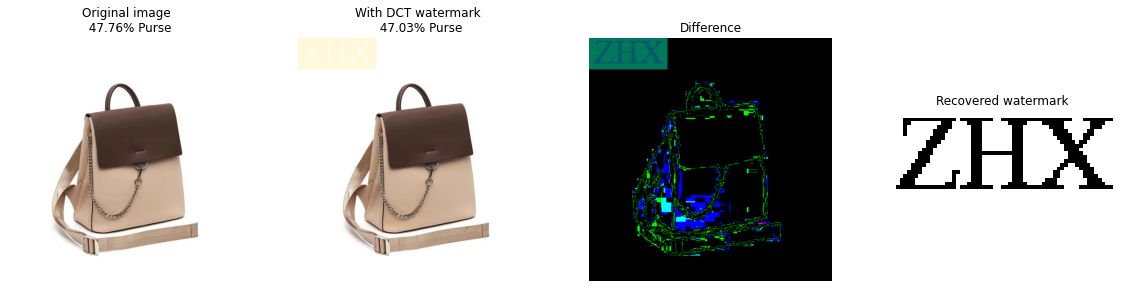

In [75]:
alpha_strong = 50
wmed_img_strong = embed_wm(img,wm,block_size,k1,k2,alpha_strong)
r_wm_strong = recover_wm(wmed_img_strong,k1,k2,wm.shape,block_size)
plt.figure(figsize=(20,20))
plt.subplot(1,4,1)
plt.imshow(img)
plt.title('Original image \n 47.76% Purse')
plt.axis('off')
plt.subplot(1,4,2)
plt.imshow(wmed_img_strong)
plt.title('With DCT watermark \n 47.03% Purse')
plt.axis('off')
plt.subplot(1,4,3)
plt.imshow(wmed_img_strong-img)
plt.title('Difference')
plt.axis('off')
plt.subplot(1,4,4)
plt.imshow(r_wm_strong,cmap="gray")
plt.title('Recovered watermark')
plt.axis('off')
plt.show()

In [77]:
PSNRLossnp(wmed_img_strong,img)

56.287903437304216

In [89]:
SSIMnp(wmed_img_strong,img)

0.999997002623483

In [94]:
np.linalg.norm(wmed_img_strong-img)

61133.63970842894

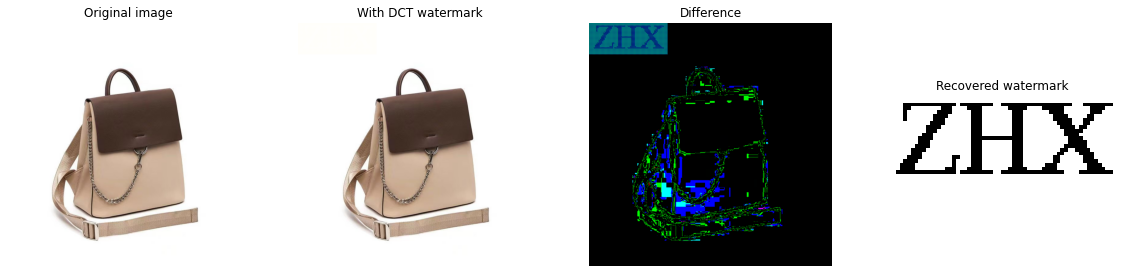

In [78]:
# embed and extract
wmed_img = embed_wm(img,wm,block_size,k1,k2,alpha)
r_wm = recover_wm(wmed_img,k1,k2,wm.shape,block_size)
plt.figure(figsize=(20,20))
plt.subplot(1,4,1)
plt.imshow(img)
plt.title('Original image')
plt.axis('off')
plt.subplot(1,4,2)
plt.imshow(wmed_img)
plt.title('With DCT watermark')
plt.axis('off')
plt.subplot(1,4,3)
plt.imshow(wmed_img-img)
plt.title('Difference')
plt.axis('off')
plt.subplot(1,4,4)
plt.imshow(r_wm,cmap="gray")
plt.title('Recovered watermark')
plt.axis('off')
plt.show()

In [91]:
PSNRLossnp(wmed_img,img)

68.09214901950882

In [92]:
SSIMnp(wmed_img,img)

0.9999995768629795

In [95]:
np.linalg.norm(wmed_img-img)

63121.88271906978

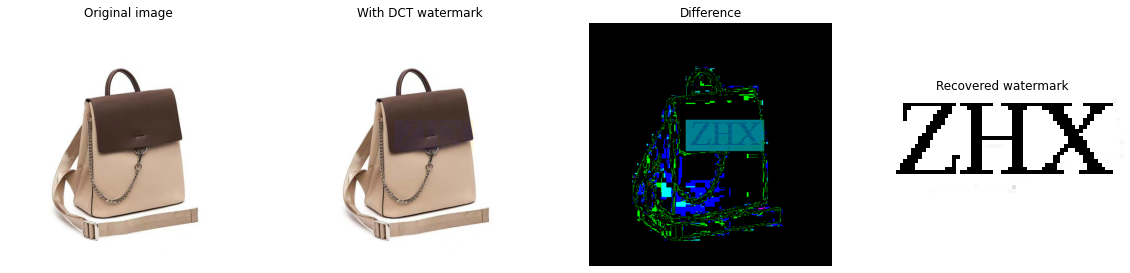

In [86]:
# embed and extract
wmed_img_loc = embed_wm(img,wm,block_size,k1,k2,alpha_strong,80,80)
r_wm_loc = recover_wm(wmed_img_loc,k1,k2,wm.shape,block_size,80,80)
plt.figure(figsize=(20,20))
plt.subplot(1,4,1)
plt.imshow(img)
plt.title('Original image')
plt.axis('off')
plt.subplot(1,4,2)
plt.imshow(wmed_img_loc)
plt.title('With DCT watermark')
plt.axis('off')
plt.subplot(1,4,3)
plt.imshow(wmed_img_loc-img)
plt.title('Difference')
plt.axis('off')
plt.subplot(1,4,4)
plt.imshow(r_wm_loc,cmap="gray")
plt.title('Recovered watermark')
plt.axis('off')
plt.show()

In [87]:
PSNRLossnp(wmed_img_loc,img)

50.42029779441178

In [93]:
SSIMnp(wmed_img_loc,img)

0.9999986182357954

In [96]:
np.linalg.norm(wmed_img_loc-img)

62641.59918935659

In [49]:
import torch
import torchvision
import torchvision.models as models
import torchvision.transforms as transforms
import torch.nn.functional as F
from torchvision.models import ResNet50_Weights

In [50]:
# check classification result for single image
# param model: torch model
# param file_path: image file path
# param transform: torchvision.transforms
def check_classify_path(model,file_path,transform):
  img = cv2.imread(file_path)
  img = cv2.cvtColor(img,cv2.COLOR_BGR2RGB)
  img = torch.unsqueeze(transform(img),0).cuda()
  out = (F.softmax(model(img),dim=1))
  print(torch.max(out))
  print(out.argmax())
# check classification result for single image
# param model: torch model
# param img: 3-dim image array
# param transform: torchvision.transforms
def check_classify_array(model,img,transform):
  img = torch.unsqueeze(transform(img),0).cuda()
  out = (F.softmax(model(img),dim=1))
  print(torch.max(out))
  print(out.argmax())
# check classification result for single image
# param model: torch model
# param img: 4-dim image tensor
def check_classify_tensor(model,img):
  out = (F.softmax(model(img),dim=1))
  print(torch.max(out))
  print(out.argmax())

In [51]:
# Transform np array to Tensor
T = transforms.ToTensor()

In [52]:
# convert tensor to PILImage (for presentation)
from torchvision.transforms import ToPILImage
show = ToPILImage()

In [53]:
from torch import Tensor
from torchvision.models.resnet import ResNet
from torch import nn
from typing import Optional, Any, List, Callable, Type, Union
from torchvision.models.resnet import BasicBlock,Bottleneck
class ResNet_with_trans(ResNet):
    def forward(self, x: Tensor) -> Tensor:
        x = transforms.Resize([256,256])(x)
        x = transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])(x)
        return self._forward_impl(x)

In [54]:
from torchvision.models.resnet import ResNet50_Weights
from torchvision.models._utils import _ovewrite_named_param
def resnet50_with_trans(*, weights: Optional[ResNet50_Weights] = None, progress: bool = True, **kwargs: Any) -> ResNet:
    weights = ResNet50_Weights.verify(weights)
    # model = _resnet(Bottleneck, [3, 4, 6, 3], weights, progress, **kwargs)
    block = Bottleneck
    layers = [3, 4, 6, 3]

    if weights is not None:
        _ovewrite_named_param(kwargs, "num_classes", len(weights.meta["categories"]))

    model = ResNet_with_trans(block, layers, **kwargs)

    if weights is not None:
        model.load_state_dict(weights.get_state_dict(progress=progress))
    
    return model

In [55]:
resnet_t = resnet50_with_trans(weights=ResNet50_Weights.IMAGENET1K_V1)
resnet_t = resnet_t.cuda()
resnet_t = resnet_t.eval()

In [56]:
check_classify_array(resnet_t,img,T)

tensor(0.4776, device='cuda:0', grad_fn=<MaxBackward1>)
tensor(748, device='cuda:0')


In [57]:
check_classify_array(resnet_t,wmed_img,T)

tensor(0.4846, device='cuda:0', grad_fn=<MaxBackward1>)
tensor(748, device='cuda:0')


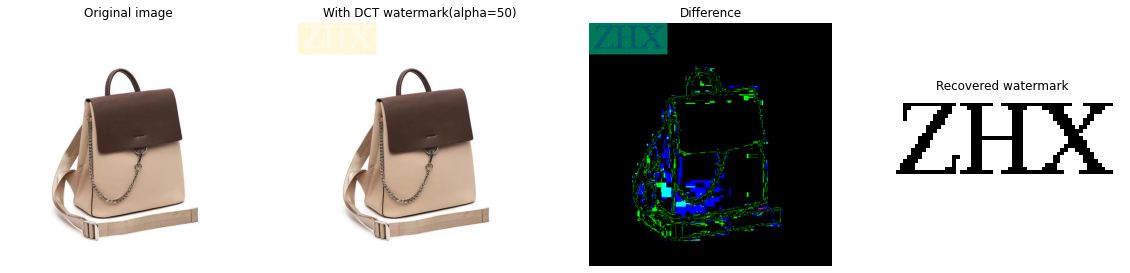

In [59]:
plt.figure(figsize=(20,20))
plt.subplot(1,4,1)
plt.imshow(img)
plt.title('Original image')
plt.axis('off')
plt.subplot(1,4,2)
plt.imshow(wmed_img_strong)
plt.title('With DCT watermark(alpha=50)')
plt.axis('off')
plt.subplot(1,4,3)
plt.imshow(wmed_img_strong-img)
plt.title('Difference')
plt.axis('off')
plt.subplot(1,4,4)
plt.imshow(r_wm,cmap="gray")
plt.title('Recovered watermark')
plt.axis('off')
plt.show()

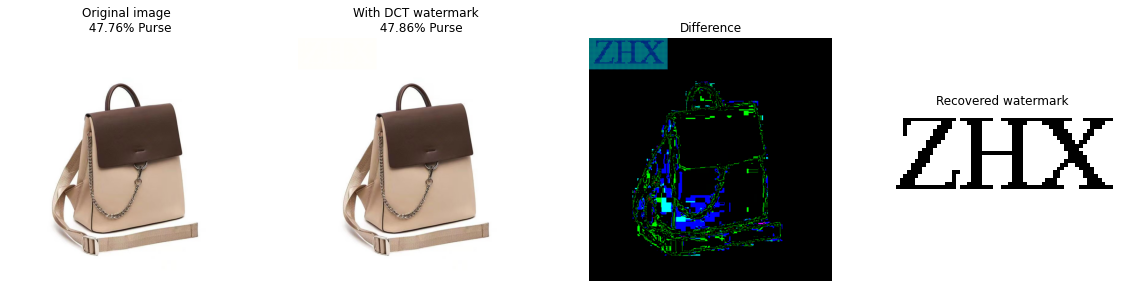

In [60]:
plt.figure(figsize=(20,20))
plt.subplot(1,4,1)
plt.imshow(img)
plt.title('Original image \n 47.76% Purse')
plt.axis('off')
plt.subplot(1,4,2)
plt.imshow(wmed_img)
plt.title('With DCT watermark  \n 47.86% Purse')
plt.axis('off')
plt.subplot(1,4,3)
plt.imshow(wmed_img-img)
plt.title('Difference')
plt.axis('off')
plt.subplot(1,4,4)
plt.imshow(r_wm,cmap="gray")
plt.title('Recovered watermark')
plt.axis('off')
plt.show()

In [61]:
check_classify_array(resnet_t,wmed_img_strong,T)

tensor(0.4297, device='cuda:0', grad_fn=<MaxBackward1>)
tensor(748, device='cuda:0')


In [62]:
def attack_and_check(model,T,atk,img,target):
  origin = torch.unsqueeze(T(img),0).cuda()
  adv_images = atk(origin, target)
  out_per = (F.softmax(model(adv_images),dim=1))
  print(torch.max(out_per))
  print(out_per.argmax())
  adv_image = show(adv_images.cpu().detach()[0])
  # adv_image.show()
  return np.array(adv_image)

In [63]:
import torchattacks

In [64]:
pgd_atk = torchattacks.PGD(resnet_t, eps=8/255, alpha=1/255, steps=40, random_start=True)
pgd_img = attack_and_check(resnet_t,T,pgd_atk,wmed_img,target)

tensor(1.0000, device='cuda:0', grad_fn=<MaxBackward1>)
tensor(748, device='cuda:0')


In [65]:
def show_2_img_diff(img1,img2,res1='',res2=''):
    plt.figure(figsize=(20,20))
    plt.subplot(1,3,1)
    plt.imshow(img1)
    plt.title('With DCT watermark \n%s'%res1)
    plt.axis('off')
    plt.subplot(1,3,2)
    plt.imshow(img2)
    plt.title('After perturbation \n%s'%res2)
    plt.axis('off')
    plt.subplot(1,3,3)
    plt.imshow(img2-img1)
    plt.title('Difference')
    plt.axis('off')
    plt.show()

In [66]:
def show_wm_after_atk(img1,img2,res1='',res2='',
                      k1=k1,k2=k2,wm_shape=wm.shape,block_size=block_size,atk_type=' '):
    plt.figure(figsize=(20,20))
    plt.subplot(1,4,1)
    plt.imshow(img1)
    plt.title('With DCT watermark \n%s'%res1)
    plt.axis('off')
    plt.subplot(1,4,2)
    plt.imshow(img2)
    plt.title('After{}perturbation \n{}'.format(atk_type,res2))
    plt.axis('off')
    plt.subplot(1,4,3)
    plt.imshow(img2-img1)
    plt.title('Difference')
    plt.axis('off')
    r_wm = recover_wm(img2,k1,k2,wm_shape,block_size)
    plt.subplot(1,4,4)
    plt.imshow(r_wm,cmap='gray')
    plt.title('Extracted watermark (with perturbation)')
    plt.axis('off')
    plt.show()

In [67]:
pgd_img_strongwm = attack_and_check(resnet_t,T,pgd_atk,wmed_img_strong,target)

tensor(1.0000, device='cuda:0', grad_fn=<MaxBackward1>)
tensor(748, device='cuda:0')


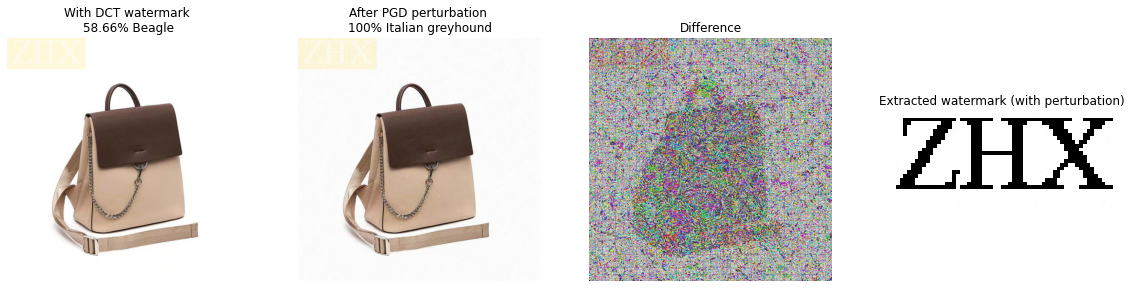

In [68]:
show_wm_after_atk(wmed_img_strong,pgd_img_strongwm,res1='58.66% Beagle',res2='100% Italian greyhound',atk_type=' PGD ')

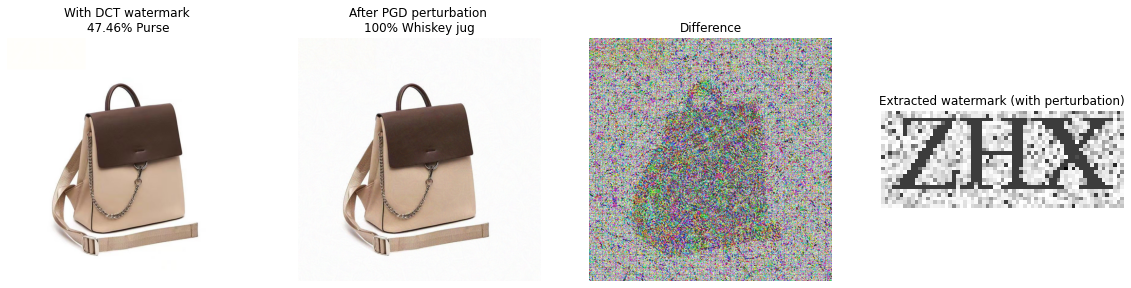

In [69]:
show_wm_after_atk(wmed_img,pgd_img,res1='47.46% Purse',res2='100% Whiskey jug',atk_type=' PGD ')

In [70]:
def show_img_and_wm(img,k1,k2,wm_shape,block_size):
    r_wm = recover_wm(img,k1,k2,wm_shape,block_size)
    plt.figure(figsize=(20,20))
    plt.subplot(1,2,1)
    plt.imshow(wmed_img)
    plt.title('Original image')
    plt.axis('off')
    plt.subplot(1,2,2)
    plt.imshow(r_wm,cmap='gray')
    plt.title('Extracted watermark')
    plt.axis('off')
    plt.show()

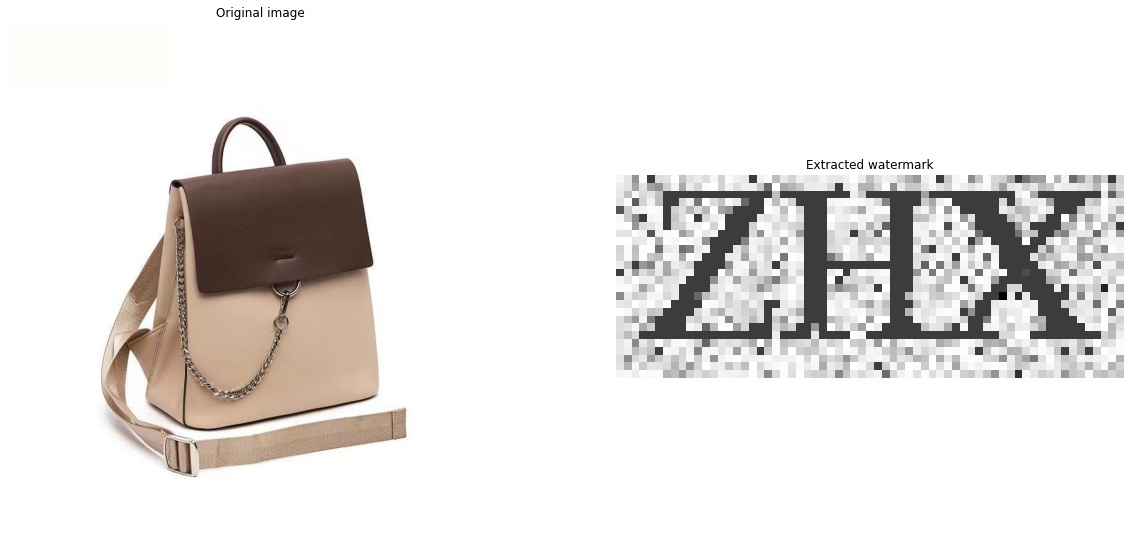

In [71]:
show_img_and_wm(pgd_img,k1,k2,wm.shape,block_size)

In [72]:
cw_atk = torchattacks.CW(resnet_t, c=1, kappa=0, steps=1000, lr=0.01)
cw_img = attack_and_check(resnet_t,T,cw_atk,wmed_img,target)

tensor(0.4847, device='cuda:0', grad_fn=<MaxBackward1>)
tensor(748, device='cuda:0')


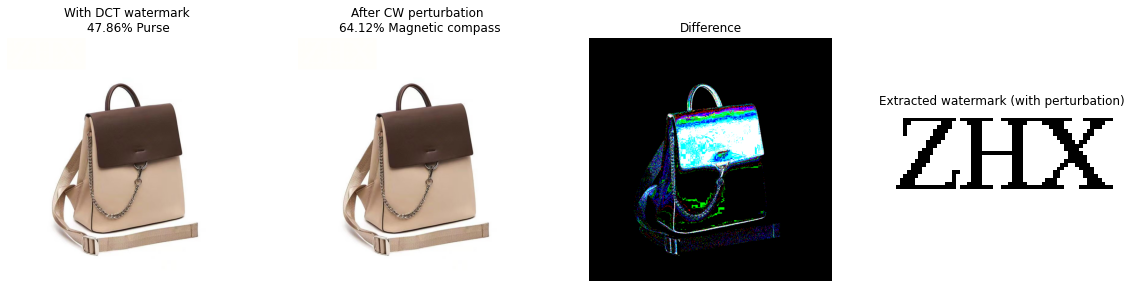

In [73]:
show_wm_after_atk(wmed_img,cw_img,res1='47.86% Purse',res2='64.12% Magnetic compass',atk_type=' CW ')

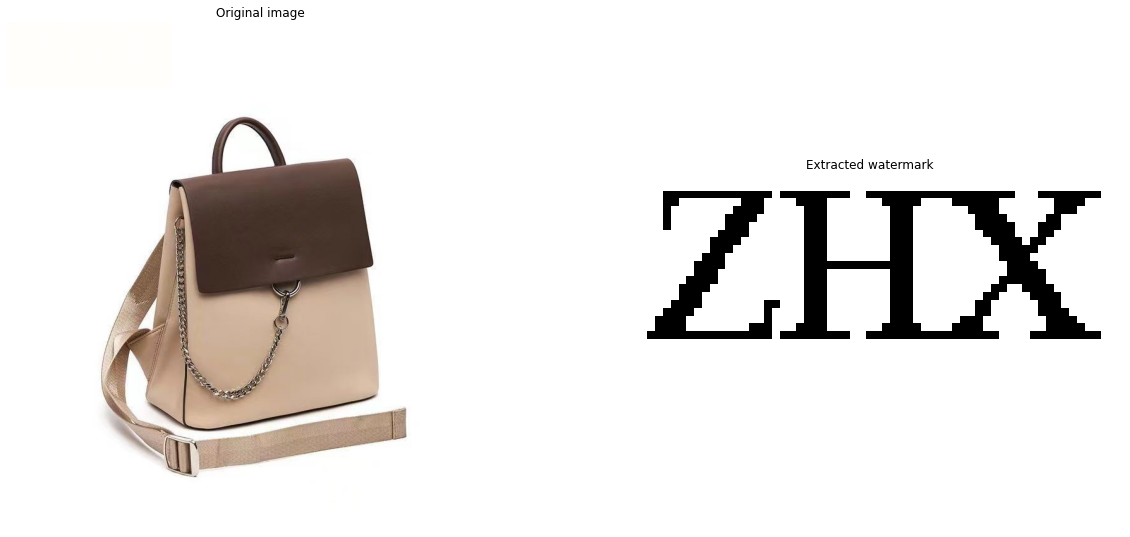

In [74]:
show_img_and_wm(cw_img,k1,k2,wm.shape,block_size)

* PGD攻击：攻击效果强 水印提取效果差
* CW攻击：攻击效果逊于PGD 但水印提取效果好\
解决该问题的一种策略是增强水印施加的强度 但会影响图像的视觉效果